In [104]:
# Study5_final.py
# ------------------------------------------------------------
# Clean, single-source-of-truth pipeline for Study 5 (event-based)
# Jeppesen-compatible:
#   - CSI100 computed on RAW RR (no 7RR median prefilter)
#   - ModCSI100_filt computed on 7RR median-filtered RR (tachogram prefilter)
#   - Slope computed on HR (bpm) derived from FILTERED RR, using abs(LS slope)
#   - Products:
#       * CSI100_x_SlopeHR
#       * ModCSI100_filt_x_SlopeHR
#
# This file is intentionally self-contained (no legacy dependencies).
# ------------------------------------------------------------

from __future__ import annotations

import re
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Optional, List, Tuple

import numpy as np
import pandas as pd


# ============================================================
# 0) IO + indexing helpers
# ============================================================

_RX = re.compile(
    r"^P(?P<pid>\d{2})(?P<enr>[a-z]?)_R(?P<rec>\d{2})_(?P<algo>[^_]+)_rr_aligned\.csv$",
    re.IGNORECASE
)


def parse_rr_filename(p: Path) -> dict:
    m = _RX.match(p.name)
    if not m:
        raise ValueError(f"Cannot parse filename: {p.name}")
    return {
        "patient_number": int(m.group("pid")),           # 1..43
        "enrollment_id": (m.group("enr") or ""),         # "" / "a" / "b" / "c"
        "recording_id": int(m.group("rec")),             # 1..99
        "algo_id": m.group("algo").lower(),
    }


def _norm_enrollment(x) -> str:
    if x is None:
        return ""
    if isinstance(x, float) and np.isnan(x):
        return ""
    s = str(x).strip()
    if s.lower() == "nan":
        return ""
    return s


def lookup_recording_uid(meta: dict, df_rec_index: pd.DataFrame) -> int:
    """
    Find recording_uid from (patient_id, enrollment_id, recording_id)
    """
    pid = int(meta["patient_number"])
    enr = _norm_enrollment(meta["enrollment_id"]).lower()
    rec = int(meta["recording_id"])

    cand = df_rec_index.copy()
    cand["enrollment_id_norm"] = cand["enrollment_id"].apply(_norm_enrollment).str.lower()

    m = cand[
        (cand["patient_id"].astype(int) == pid)
        & (cand["enrollment_id_norm"] == enr)
        & (cand["recording_id"].astype(int) == rec)
    ]
    if len(m) != 1:
        base = cand[(cand["patient_id"].astype(int) == pid) & (cand["enrollment_id_norm"] == enr)]
        raise KeyError(
            f"UID lookup failed: pid={pid} enr='{enr}' rec={rec} (n={len(m)}). "
            f"Available recording_id for this pid/enr: {sorted(base['recording_id'].unique().tolist())}"
        )
    return int(m.iloc[0]["recording_uid"])


def load_thr_maps_from_excel(
    thr_xlsx_path: str | Path,
    *,
    pid_col: str = "Patient number",
    modcsi_col: str = "Threshold ModCSI100_filt x slope",
    csi_col: str = "Threshold CSI100 x slope",
) -> tuple[dict[int, float], dict[int, float]]:
    thr_df = pd.read_excel(thr_xlsx_path)

    thr_map_modcsi = (
        thr_df.set_index(pid_col)[modcsi_col].dropna().to_dict()
    )
    thr_map_csi = (
        thr_df.set_index(pid_col)[csi_col].dropna().to_dict()
    )
    thr_map_modcsi = {int(k): float(v) for k, v in thr_map_modcsi.items()}
    thr_map_csi = {int(k): float(v) for k, v in thr_map_csi.items()}
    return thr_map_modcsi, thr_map_csi


def load_df_seiz(seiz_csv_or_df: str | Path | pd.DataFrame) -> pd.DataFrame:
    """
    Expected minimum:
      recording_uid, t0_clinical, t1_clinical
    """
    df = pd.read_csv(seiz_csv_or_df) if isinstance(seiz_csv_or_df, (str, Path)) else seiz_csv_or_df.copy()

    req = {"recording_uid", "t0_clinical", "t1_clinical"}
    miss = req - set(df.columns)
    if miss:
        raise KeyError(f"seizure_events missing columns: {miss}")

    df["recording_uid"] = pd.to_numeric(df["recording_uid"], errors="coerce")
    df["t0_clinical"] = pd.to_numeric(df["t0_clinical"], errors="coerce")
    df["t1_clinical"] = pd.to_numeric(df["t1_clinical"], errors="coerce")
    df = df.dropna(subset=["recording_uid"]).copy()
    df["recording_uid"] = df["recording_uid"].astype(int)
    return df


def make_windows_df_from_sqi_and_seiz(
    winq_csv_or_df: str | Path | pd.DataFrame,
    df_seiz: pd.DataFrame,
    *,
    t0_col: str = "t0_clinical",
    t1_col: str = "t1_clinical",
    # accept-regel: accepter kun hvis ingen af disse flags er True
    flatline_col: str = "is_flatline",
    noiseburst_col: str = "is_noiseburst",
    clipping_col: str = "is_clipping",
) -> pd.DataFrame:
    """
    Build windows_df with required columns:
      recording_uid, win_start_s, win_end_s, is_acceptable, window_overlaps_seizure

    Source:
      - winq file provides per-window SQI flags
      - df_seiz provides seizure intervals (t0/t1 in seconds)

    Assumptions:
      - A window is acceptable if NOT (flatline OR noiseburst OR clipping).
      - A window overlaps seizure if [win_start, win_end] overlaps [t0, t1].
    """
    w = pd.read_csv(winq_csv_or_df) if isinstance(winq_csv_or_df, (str, Path)) else winq_csv_or_df.copy()

    # required window columns
    req_w = {"recording_uid", "win_start_s", "win_end_s", flatline_col, noiseburst_col, clipping_col}
    miss_w = req_w - set(w.columns)
    if miss_w:
        raise KeyError(f"window_quality missing columns: {miss_w}. Found: {list(w.columns)}")

    # required seizure columns
    req_s = {"recording_uid", t0_col, t1_col}
    miss_s = req_s - set(df_seiz.columns)
    if miss_s:
        raise KeyError(f"df_seiz missing columns: {miss_s}. Found: {list(df_seiz.columns)}")

    # coerce types
    w["recording_uid"] = pd.to_numeric(w["recording_uid"], errors="coerce")
    w["win_start_s"] = pd.to_numeric(w["win_start_s"], errors="coerce")
    w["win_end_s"] = pd.to_numeric(w["win_end_s"], errors="coerce")
    w = w.dropna(subset=["recording_uid", "win_start_s", "win_end_s"]).copy()
    w["recording_uid"] = w["recording_uid"].astype(int)

    def _to_bool(col: pd.Series) -> pd.Series:
        if col.dtype == bool:
            return col
        v = col.astype(str).str.strip().str.lower()
        return v.isin(["1", "true", "t", "yes", "y"])

    w[flatline_col] = _to_bool(w[flatline_col])
    w[noiseburst_col] = _to_bool(w[noiseburst_col])
    w[clipping_col] = _to_bool(w[clipping_col])

    # define acceptability
    w["is_acceptable"] = ~(w[flatline_col] | w[noiseburst_col] | w[clipping_col])

    # compute seizure overlap per window (per recording)
    seiz = df_seiz.copy()
    seiz["recording_uid"] = pd.to_numeric(seiz["recording_uid"], errors="coerce")
    seiz[t0_col] = pd.to_numeric(seiz[t0_col], errors="coerce")
    seiz[t1_col] = pd.to_numeric(seiz[t1_col], errors="coerce")
    seiz = seiz.dropna(subset=["recording_uid", t0_col, t1_col]).copy()
    seiz["recording_uid"] = seiz["recording_uid"].astype(int)

    # default: no overlap
    w["window_overlaps_seizure"] = False

    # efficient-ish per recording loop
    for rid, gw in w.groupby("recording_uid", sort=False):
        gs = seiz[seiz["recording_uid"] == rid]
        if gs.empty:
            continue

        win_start = gw["win_start_s"].to_numpy(dtype=float)
        win_end = gw["win_end_s"].to_numpy(dtype=float)

        overlaps = np.zeros(win_start.shape[0], dtype=bool)
        for _, srow in gs.iterrows():
            a = float(srow[t0_col])
            b = float(srow[t1_col])
            overlaps |= (win_end >= a) & (win_start <= b)

        w.loc[gw.index, "window_overlaps_seizure"] = overlaps

    return w[["recording_uid", "win_start_s", "win_end_s", "is_acceptable", "window_overlaps_seizure"]].copy()




# ============================================================
# 1) Core HRV features (Jeppesen-compatible)
# ============================================================

def clean_rr(rr_s: np.ndarray, *, min_s: float = 0.25, max_s: float = 2.5) -> np.ndarray:
    rr = np.asarray(rr_s, float)
    rr = rr[np.isfinite(rr)]
    rr = rr[(rr >= min_s) & (rr <= max_s)]
    return rr


def median_prefilter_7(rr_s: np.ndarray) -> np.ndarray:
    """
    "previous seven RR intervals" causal median filter.
    """
    rr = np.asarray(rr_s, float)
    out = np.empty_like(rr)
    for i in range(rr.size):
        j0 = max(0, i - 6)
        out[i] = np.median(rr[j0:i+1])
    return out


def poincare_sd1_sd2(rr_s_win: np.ndarray) -> tuple[float, float]:
    rr = np.asarray(rr_s_win, float)
    if rr.size < 3:
        return np.nan, np.nan
    x = rr[:-1]
    y = rr[1:]
    sd1 = np.std((y - x) / np.sqrt(2.0), ddof=1)
    sd2 = np.std((y + x) / np.sqrt(2.0), ddof=1)
    return float(sd1), float(sd2)


def csi_from_sd(sd1: float, sd2: float) -> float:
    T = 4.0 * sd1
    L = 4.0 * sd2
    if not (np.isfinite(T) and np.isfinite(L) and T > 0):
        return np.nan
    return float(L / T)


def modcsi_from_sd(sd1: float, sd2: float) -> float:
    T = 4.0 * sd1
    L = 4.0 * sd2
    if not (np.isfinite(T) and np.isfinite(L) and T > 0):
        return np.nan
    return float((L * L) / T)


def slope_ls_abs(t_s: np.ndarray, y: np.ndarray) -> float:
    """
    abs(OLS slope) = |cov(t,y)/var(t)|, units: y per second.
    """
    t = np.asarray(t_s, float)
    y = np.asarray(y, float)
    if t.size < 3:
        return np.nan
    t0 = t - t.mean()
    y0 = y - y.mean()
    denom = np.sum(t0 * t0)
    if denom <= 0:
        return np.nan
    a = np.sum(t0 * y0) / denom
    return float(abs(a))


def compute_csi_modcsi_slope_jeppesen(rr_s_raw: np.ndarray, *, win_rr: int = 100) -> pd.DataFrame:
    """
    Output aligned to window END index:
      - CSI100: RAW RR
      - ModCSI100_filt: 7RR-median-filtered RR
      - SlopeHR100_abs_bpm_per_s: LS slope on HR(bpm) derived from FILTERED RR
      - Products: CSI100_x_SlopeHR, ModCSI100_filt_x_SlopeHR
    Time axis t_s uses cumulative sum of FILTERED RR (consistent with slope window).
    """
    rr_raw = np.asarray(rr_s_raw, float)
    rr_raw = rr_raw[np.isfinite(rr_raw)]
    if rr_raw.size < win_rr:
        return pd.DataFrame()

    rr_f = median_prefilter_7(rr_raw)

    t_end = np.cumsum(rr_f)  # seconds since start
    hr_f = 60.0 / np.maximum(rr_f, 1e-12)  # bpm

    rows = []
    n = rr_raw.size
    for k_end in range(win_rr - 1, n):
        sl = slice(k_end - win_rr + 1, k_end + 1)

        rr_win_raw = rr_raw[sl]
        rr_win_f = rr_f[sl]
        t_win = t_end[sl]
        hr_win = hr_f[sl]

        sd1_raw, sd2_raw = poincare_sd1_sd2(rr_win_raw)
        csi_100 = csi_from_sd(sd1_raw, sd2_raw)

        sd1_f, sd2_f = poincare_sd1_sd2(rr_win_f)
        modcsi_100_f = modcsi_from_sd(sd1_f, sd2_f)

        slope_hr = 60.0 * slope_ls_abs(t_win, hr_win)  # bpm/min

        rows.append(
            {
                "k_end": int(k_end),
                "t_s": float(t_end[k_end]),
                "CSI100": csi_100,
                "ModCSI100_filt": modcsi_100_f,
                "SlopeHR100_abs_bpm_per_min": slope_hr,
                "CSI100_x_SlopeHR": (csi_100 * slope_hr) if np.isfinite(csi_100) and np.isfinite(slope_hr) else np.nan,
                "ModCSI100_filt_x_SlopeHR": (modcsi_100_f * slope_hr) if np.isfinite(modcsi_100_f) and np.isfinite(slope_hr) else np.nan,
            }
        )

    return pd.DataFrame(rows)


# ============================================================
# 2) Map features → Study4 windows
# ============================================================

def map_points_to_windows(df_feat: pd.DataFrame, windows_df: pd.DataFrame) -> pd.DataFrame:
    """
    Map each feature point t_s to its Study4 window in windows_df for the same recording_uid.
    windows_df must have: recording_uid, win_start_s, win_end_s, is_acceptable, window_overlaps_seizure.
    """
    f = df_feat.copy()
    w = windows_df[["recording_uid", "win_start_s", "win_end_s", "is_acceptable", "window_overlaps_seizure"]].copy()

    f["recording_uid"] = pd.to_numeric(f["recording_uid"], errors="coerce")
    f["t_s"] = pd.to_numeric(f["t_s"], errors="coerce")
    f = f.dropna(subset=["recording_uid", "t_s"]).copy()
    f["recording_uid"] = f["recording_uid"].astype(int)

    w["recording_uid"] = pd.to_numeric(w["recording_uid"], errors="coerce")
    w["win_start_s"] = pd.to_numeric(w["win_start_s"], errors="coerce")
    w["win_end_s"] = pd.to_numeric(w["win_end_s"], errors="coerce")
    w = w.dropna(subset=["recording_uid", "win_start_s", "win_end_s"]).copy()
    w["recording_uid"] = w["recording_uid"].astype(int)

    out_parts = []

    for rid, g in f.groupby("recording_uid", sort=False):
        ww = w[w["recording_uid"] == rid].copy()
        if ww.empty:
            continue

        ww = ww.sort_values("win_start_s", kind="mergesort").reset_index(drop=True)
        starts = ww["win_start_s"].to_numpy(dtype=float)
        ends = ww["win_end_s"].to_numpy(dtype=float)

        t = g["t_s"].to_numpy(dtype=float)
        idx = np.searchsorted(starts, t, side="right") - 1
        ok = (idx >= 0) & (t < ends[np.clip(idx, 0, len(ends) - 1)])
        if not np.any(ok):
            continue

        gg = g.iloc[np.where(ok)[0]].copy()
        idx_ok = idx[ok]

        gg["win_start_s"] = starts[idx_ok]
        gg["win_end_s"] = ends[idx_ok]
        gg["is_acceptable"] = ww["is_acceptable"].to_numpy()[idx_ok]
        gg["window_overlaps_seizure"] = ww["window_overlaps_seizure"].to_numpy()[idx_ok]

        gg["group"] = np.where(gg["window_overlaps_seizure"], "seizure", "baseline")
        gg["q"] = np.where(gg["is_acceptable"], "accepted", "rejected")

        out_parts.append(gg)

    if not out_parts:
        return pd.DataFrame(
            columns=list(df_feat.columns)
            + ["win_start_s", "win_end_s", "is_acceptable", "window_overlaps_seizure", "group", "q"]
        )

    return pd.concat(out_parts, ignore_index=True)


# ============================================================
# 3) Build df_feat from rr_aligned folder
# ============================================================

def build_features_from_rr_folder(
    rr_dir: Path,
    *,
    df_rec_index: pd.DataFrame,
    windows_df: pd.DataFrame,
    thr_map_modcsi: Dict[int, float],
    thr_map_csi: Dict[int, float],
    rr_source: str,                          # "labview" or "python"
    rr_col: str,                             # "RR_labview_s" or "RR_python_s"
    algo_keep: Optional[set] = None,
    recording_uid_keep: Optional[set] = None,
    set_label: str = "trim",
    win_rr: int = 100,
    rr_min_s: float = 0.25,
    rr_max_s: float = 2.5,
) -> pd.DataFrame:
    rows: List[pd.DataFrame] = []

    for p in sorted(rr_dir.glob("*.csv")):
        meta = parse_rr_filename(p)
        algo_id = meta["algo_id"]

        if algo_keep is not None and algo_id not in algo_keep:
            continue

        rid = lookup_recording_uid(meta, df_rec_index)
        if recording_uid_keep is not None and rid not in recording_uid_keep:
            continue

        pid = int(meta["patient_number"])
        thr_mod = float(thr_map_modcsi.get(pid, np.nan))
        thr_csi = float(thr_map_csi.get(pid, np.nan))

        df_rr = pd.read_csv(p)
        if rr_col not in df_rr.columns:
            continue

        rr_s = pd.to_numeric(df_rr[rr_col], errors="coerce").to_numpy(dtype=float)
        rr_s = clean_rr(rr_s, min_s=rr_min_s, max_s=rr_max_s)
        if rr_s.size < win_rr:
            continue

        feat = compute_csi_modcsi_slope_jeppesen(rr_s, win_rr=win_rr)
        if feat.empty:
            continue

        feat["recording_uid"] = int(rid)
        feat["patient_id"] = int(pid)
        feat["algo_id"] = str(algo_id)
        feat["rr_source"] = str(rr_source)
        feat["set"] = str(set_label)
        feat["win_rr"] = int(win_rr)

        feat["thr_modcsi"] = thr_mod
        feat["thr_csi"] = thr_csi

        feat = map_points_to_windows(feat, windows_df)
        rows.append(feat)

    out = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

    # Hard guard: ensure expected final columns exist
    required = {
        "recording_uid", "patient_id", "t_s",
        "CSI100_x_SlopeHR", "ModCSI100_filt_x_SlopeHR",
        "thr_csi", "thr_modcsi",
        "win_start_s", "win_end_s", "is_acceptable", "window_overlaps_seizure"
    }
    if not out.empty:
        miss = required - set(out.columns)
        if miss:
            raise RuntimeError(f"Feature build missing required columns: {miss}")

    return out


# ============================================================
# 4) Event-based scoring
# ============================================================

def _extract_events_from_series(t: np.ndarray, x: np.ndarray, *, gap_s: float) -> list[dict]:
    if t.size == 0:
        return []
    dt = np.diff(t)
    splits = np.where(dt > gap_s)[0] + 1
    groups = np.split(np.arange(t.size), splits)

    events = []
    for idx in groups:
        tt = t[idx]
        xx = x[idx]
        k = int(np.argmax(xx))
        events.append(
            {
                "t_start": float(tt[0]),
                "t_end": float(tt[-1]),
                "duration_s": float(tt[-1] - tt[0]),
                "t_peak": float(tt[k]),
                "peak_value": float(xx[k]),
                "n_points": int(len(idx)),
            }
        )
    return events


def build_event_list(
    df_feat: pd.DataFrame,
    *,
    value_col: str,
    thr_col: str,
    time_col: str = "t_s",
    gap_s: float = 180.0,
) -> pd.DataFrame:
    need = {"recording_uid", time_col, value_col, thr_col}
    miss = need - set(df_feat.columns)
    if miss:
        raise KeyError(f"df_feat missing columns: {miss}")

    df = df_feat.copy()
    df["recording_uid"] = pd.to_numeric(df["recording_uid"], errors="coerce")
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df[thr_col] = pd.to_numeric(df[thr_col], errors="coerce")
    df = df.dropna(subset=["recording_uid", time_col, value_col, thr_col]).copy()
    df["recording_uid"] = df["recording_uid"].astype(int)

    out = []
    for rid, g in df.groupby("recording_uid", sort=False):
        thr = float(g[thr_col].iloc[0])
        gg = g[g[value_col] > thr].sort_values(time_col, kind="mergesort")
        if gg.empty:
            continue

        t = gg[time_col].to_numpy(dtype=float)
        x = gg[value_col].to_numpy(dtype=float)

        for e in _extract_events_from_series(t, x, gap_s=gap_s):
            out.append({"recording_uid": int(rid), **e})

    return pd.DataFrame(out) if out else pd.DataFrame(
        columns=["recording_uid", "t_start", "t_end", "duration_s", "t_peak", "peak_value", "n_points"]
    )


def analyzable_hours_from_windows(df_feat: pd.DataFrame, *, use_sqi: bool) -> float:
    need = {"recording_uid", "win_start_s", "win_end_s", "is_acceptable"}
    miss = need - set(df_feat.columns)
    if miss:
        raise KeyError(f"df_feat missing columns for time accounting: {miss}")

    w = df_feat[["recording_uid", "win_start_s", "win_end_s", "is_acceptable"]].drop_duplicates().copy()
    w["recording_uid"] = pd.to_numeric(w["recording_uid"], errors="coerce")
    w["win_start_s"] = pd.to_numeric(w["win_start_s"], errors="coerce")
    w["win_end_s"] = pd.to_numeric(w["win_end_s"], errors="coerce")
    w = w.dropna(subset=["recording_uid", "win_start_s", "win_end_s"]).copy()
    w["recording_uid"] = w["recording_uid"].astype(int)

    if use_sqi:
        w = w[w["is_acceptable"].astype(bool)]

    dur_s = (w["win_end_s"] - w["win_start_s"]).clip(lower=0).sum()
    return float(dur_s / 3600.0)


def score_pipeline_events(
    df_feat: pd.DataFrame,
    df_seiz: pd.DataFrame,
    *,
    value_col: str,
    thr_col: str,
    time_col: str = "t_s",
    t0_col: str = "t0_clinical",
    t1_col: str = "t1_clinical",
    pad_s: float = 300.0,
    gap_s: float = 180.0,
    use_sqi: bool = False,
) -> dict:
    feat = df_feat.copy()
    if use_sqi:
        feat = feat[feat["is_acceptable"].astype(bool)].copy()

    used_rids = (
        pd.to_numeric(feat["recording_uid"], errors="coerce")
        .dropna()
        .astype(int)
        .unique()
    )

    total_h = analyzable_hours_from_windows(df_feat, use_sqi=use_sqi)

    seiz = df_seiz.copy()
    for c in ["recording_uid", t0_col, t1_col]:
        if c not in seiz.columns:
            raise KeyError(f"df_seiz missing column: {c}")

    seiz["recording_uid"] = pd.to_numeric(seiz["recording_uid"], errors="coerce")
    seiz[t0_col] = pd.to_numeric(seiz[t0_col], errors="coerce")
    seiz[t1_col] = pd.to_numeric(seiz[t1_col], errors="coerce")
    seiz_raw = seiz.dropna(subset=["recording_uid"]).copy()
    seiz_raw["recording_uid"] = seiz_raw["recording_uid"].astype(int)
    n_seiz_in_used_recordings_raw = int(seiz_raw[seiz_raw["recording_uid"].isin(used_rids)].shape[0])

    seiz = seiz.dropna(subset=["recording_uid", t0_col, t1_col]).copy()
    seiz["recording_uid"] = seiz["recording_uid"].astype(int)
    n_seiz_total_defined = int(len(seiz))
    n_seiz_total_used_defined = int(seiz[seiz["recording_uid"].isin(used_rids)].shape[0])

    df_events = build_event_list(
        feat,
        value_col=value_col,
        thr_col=thr_col,
        time_col=time_col,
        gap_s=gap_s,
    )

    if df_events.empty:
        return dict(
            n_seiz_in_used_recordings_raw=n_seiz_in_used_recordings_raw,
            n_seiz_total=n_seiz_total_defined,
            n_seiz_total_used=n_seiz_total_used_defined,
            n_seiz_detected=0,
            recall_total=(0.0 if n_seiz_total_defined else np.nan),
            recall_used=(0.0 if n_seiz_total_used_defined else np.nan),
            FP_events=0,
            FAR_per_h=(0.0 if total_h > 0 else np.nan),
            total_h=float(total_h),
            n_events=0,
            n_recordings_used=int(len(used_rids)),
        )

    detected = 0
    fp_events = 0

    for rid, ev in df_events.groupby("recording_uid", sort=False):
        seiz_r = seiz[seiz["recording_uid"] == int(rid)]

        intervals = []
        if not seiz_r.empty:
            t0s = seiz_r[t0_col].to_numpy(dtype=float) - pad_s
            t1s = seiz_r[t1_col].to_numpy(dtype=float) + pad_s
            intervals = list(zip(t0s, t1s))

        if intervals:
            for _, s in seiz_r.iterrows():
                a = float(s[t0_col]) - pad_s
                b = float(s[t1_col]) + pad_s
                hit = ((ev["t_end"] >= a) & (ev["t_start"] <= b)).any()
                detected += int(hit)

        if intervals:
            e_start = ev["t_start"].to_numpy(dtype=float)
            e_end = ev["t_end"].to_numpy(dtype=float)
            inside_any = np.zeros(len(ev), dtype=bool)
            for (a, b) in intervals:
                inside_any |= (e_end >= a) & (e_start <= b)
            fp_events += int((~inside_any).sum())
        else:
            fp_events += int(len(ev))

    recall_total = detected / n_seiz_total_defined if n_seiz_total_defined else np.nan
    recall_used = detected / n_seiz_total_used_defined if n_seiz_total_used_defined else np.nan
    far = fp_events / total_h if total_h > 0 else np.nan

    return dict(
        n_seiz_in_used_recordings_raw=n_seiz_in_used_recordings_raw,
        n_seiz_total=n_seiz_total_defined,
        n_seiz_total_used=n_seiz_total_used_defined,
        n_seiz_detected=int(detected),
        recall_total=float(recall_total) if np.isfinite(recall_total) else recall_total,
        recall_used=float(recall_used) if np.isfinite(recall_used) else recall_used,
        FP_events=int(fp_events),
        FAR_per_h=float(far) if np.isfinite(far) else far,
        total_h=float(total_h),
        n_events=int(len(df_events)),
        n_recordings_used=int(len(used_rids)),
    )


# ============================================================
# 5) Table builders (overall + responder split)
# ============================================================

def add_responder_label(df: pd.DataFrame, responders: list[int], *, pid_col: str = "patient_id") -> pd.DataFrame:
    out = df.copy()
    out[pid_col] = pd.to_numeric(out[pid_col], errors="coerce")
    out["is_responder"] = out[pid_col].astype("Int64").isin(list(map(int, responders)))
    return out


def build_event_main_table(
    df_feat5: pd.DataFrame,
    df_seiz: pd.DataFrame,
    *,
    value_col: str,
    thr_col: str,
    rr_sources: tuple[str, ...] = ("labview", "python"),
    collapse_labview_algo: bool = True,
    pad_s: float = 300.0,
    gap_s: float = 180.0,
) -> pd.DataFrame:
    need = {
        "rr_source", "algo_id", "recording_uid",
        "win_start_s", "win_end_s", "is_acceptable", "window_overlaps_seizure",
        "t_s", value_col, thr_col
    }
    miss = need - set(df_feat5.columns)
    if miss:
        raise KeyError(f"df_feat5 missing columns: {miss}")

    rows = []
    for rr_src in rr_sources:
        sub = df_feat5[df_feat5["rr_source"] == rr_src].copy()
        if sub.empty:
            continue

        if rr_src == "labview" and collapse_labview_algo:
            sub = sub.copy()
            sub["algo_id"] = "LabVIEW"

        for algo, g in sub.groupby("algo_id", sort=False):
            for use_sqi in [False, True]:
                res = score_pipeline_events(
                    g, df_seiz,
                    value_col=value_col,
                    thr_col=thr_col,
                    time_col="t_s",
                    t0_col="t0_clinical",
                    t1_col="t1_clinical",
                    pad_s=pad_s,
                    gap_s=gap_s,
                    use_sqi=use_sqi,
                )
                rows.append(
                    {
                        "RR_source": ("LabVIEW" if rr_src == "labview" else "Python"),
                        "Algorithm": ("—" if (rr_src == "labview" and collapse_labview_algo) else str(algo)),
                        "SQI": ("on" if use_sqi else "off"),
                        **res,
                    }
                )

    df_out = pd.DataFrame(rows)
    if not df_out.empty:
        df_out = df_out.sort_values(["RR_source", "Algorithm", "SQI"]).reset_index(drop=True)
    return df_out


def build_event_tables_with_responder_split(
    df_feat5: pd.DataFrame,
    df_seiz: pd.DataFrame,
    responders: list[int],
    *,
    value_col: str,
    thr_col: str,
    pad_s: float = 300.0,
    gap_s: float = 180.0,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_main = build_event_main_table(
        df_feat5, df_seiz,
        value_col=value_col,
        thr_col=thr_col,
        collapse_labview_algo=True,
        pad_s=pad_s,
        gap_s=gap_s,
    )

    feat2 = add_responder_label(df_feat5, responders)
    seiz2 = add_responder_label(df_seiz, responders)

    parts = []
    for grp, gfeat in feat2.groupby("is_responder", sort=False):
        gseiz = seiz2[seiz2["is_responder"] == grp].copy()
        tab = build_event_main_table(
            gfeat, gseiz,
            value_col=value_col,
            thr_col=thr_col,
            collapse_labview_algo=True,
            pad_s=pad_s,
            gap_s=gap_s,
        )
        tab.insert(0, "is_responder", bool(grp))
        parts.append(tab)

    df_split = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    return df_main, df_split

# ===========================================================
# 5.1) Threshold validation helper
# ===========================================================
def _intervals_overlap(a0: float, a1: float, b0: float, b1: float) -> bool:
    return (a1 >= b0) and (a0 <= b1)


def _segment_has_seizure(
    seiz: pd.DataFrame,
    rid: int,
    seg_start: float,
    seg_end: float,
    *,
    t0_col: str = "t0_clinical",
    t1_col: str = "t1_clinical",
) -> bool:
    s = seiz[seiz["recording_uid"] == rid]
    if s.empty:
        return False
    t0 = s[t0_col].to_numpy(dtype=float)
    t1 = s[t1_col].to_numpy(dtype=float)
    for a, b in zip(t0, t1):
        if _intervals_overlap(seg_start, seg_end, float(a), float(b)):
            return True
    return False


def build_auto_thresholds_105pct(
    df_feat5: pd.DataFrame,
    df_seiz: pd.DataFrame,
    *,
    value_col: str,
    patient_col: str = "patient_id",
    rid_col: str = "recording_uid",
    time_col: str = "t_s",
    factor: float = 1.05,
    # candidate baseline segments (seconds)
    segs_s: tuple[tuple[str, float], ...] = (("first_24h", 24*3600), ("first_12h", 12*3600)),
    allow_half_fallback: bool = True,
    # Optional: restrict baseline to SQI-acceptable windows only
    use_sqi_for_threshold: bool = True,
    # Fallback maps (from Excel) if no seizure-free segment exists
    fallback_thr_map: Optional[dict[int, float]] = None,
) -> tuple[dict[int, float], pd.DataFrame]:
    """
    Build patient-specific thresholds as 1.05 * max(value_col) in a seizure-free baseline segment.

    Returns:
      thr_map_auto: patient_id -> threshold
      thr_meta: per-patient details about segment used and max values
    """
    req = {patient_col, rid_col, time_col, value_col}
    miss = req - set(df_feat5.columns)
    if miss:
        raise KeyError(f"df_feat5 missing required columns for auto-threshold: {miss}")

    seiz = df_seiz.copy()
    seiz["recording_uid"] = pd.to_numeric(seiz["recording_uid"], errors="coerce")
    seiz["t0_clinical"] = pd.to_numeric(seiz["t0_clinical"], errors="coerce")
    seiz["t1_clinical"] = pd.to_numeric(seiz["t1_clinical"], errors="coerce")
    seiz = seiz.dropna(subset=["recording_uid", "t0_clinical", "t1_clinical"]).copy()
    seiz["recording_uid"] = seiz["recording_uid"].astype(int)

    df = df_feat5.copy()
    df[patient_col] = pd.to_numeric(df[patient_col], errors="coerce")
    df[rid_col] = pd.to_numeric(df[rid_col], errors="coerce")
    df[time_col] = pd.to_numeric(df[time_col], errors="coerce")
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")
    df = df.dropna(subset=[patient_col, rid_col, time_col, value_col]).copy()
    df[patient_col] = df[patient_col].astype(int)
    df[rid_col] = df[rid_col].astype(int)

    if use_sqi_for_threshold:
        if "is_acceptable" not in df.columns:
            raise KeyError("use_sqi_for_threshold=True requires df_feat5['is_acceptable']")
        df = df[df["is_acceptable"].astype(bool)].copy()

    thr_map: dict[int, float] = {}
    meta_rows: list[dict] = []

    # auto-thresholds must be computed per patient, but seizures live per recording.
    for pid, gpid in df.groupby(patient_col, sort=False):
        # use all recordings for this patient in gpid
        rids = sorted(gpid[rid_col].unique().tolist())

        best = None  # (mode, rid, seg_start, seg_end, maxv)

        # try fixed segments first
        for mode, seg_end in segs_s:
            for rid in rids:
                seg_start = 0.0
                # check seizure-free
                if _segment_has_seizure(seiz, rid, seg_start, seg_end):
                    continue
                gg = gpid[(gpid[rid_col] == rid) & (gpid[time_col] >= seg_start) & (gpid[time_col] <= seg_end)]
                if gg.empty:
                    continue
                maxv = float(gg[value_col].max())
                if not np.isfinite(maxv):
                    continue
                if (best is None) or (maxv > best[4]):
                    best = (mode, rid, seg_start, seg_end, maxv)

        # half-recording fallback
        if best is None and allow_half_fallback:
            for rid in rids:
                gg_all = gpid[gpid[rid_col] == rid]
                if gg_all.empty:
                    continue
                tmax = float(gg_all[time_col].max())
                seg_start = 0.0
                seg_end = 0.5 * tmax
                if _segment_has_seizure(seiz, rid, seg_start, seg_end):
                    continue
                gg = gg_all[(gg_all[time_col] >= seg_start) & (gg_all[time_col] <= seg_end)]
                if gg.empty:
                    continue
                maxv = float(gg[value_col].max())
                if not np.isfinite(maxv):
                    continue
                best = ("first_half", rid, seg_start, seg_end, maxv)
                break

        # decide threshold
        if best is not None:
            mode, rid, seg_start, seg_end, maxv = best
            thr = float(factor * maxv)
            thr_map[int(pid)] = thr
            meta_rows.append({
                "patient_id": int(pid),
                "mode_used": mode,
                "recording_uid_used": int(rid),
                "segment_start_s": float(seg_start),
                "segment_end_s": float(seg_end),
                "max_value_in_segment": float(maxv),
                "factor": float(factor),
                "threshold": float(thr),
                "fallback_used": False,
            })
        else:
            thr_fb = None
            if fallback_thr_map is not None:
                thr_fb = fallback_thr_map.get(int(pid), None)

            thr_map[int(pid)] = float(thr_fb) if thr_fb is not None else np.nan
            meta_rows.append({
                "patient_id": int(pid),
                "mode_used": "fallback_excel" if thr_fb is not None else "no_threshold",
                "recording_uid_used": np.nan,
                "segment_start_s": np.nan,
                "segment_end_s": np.nan,
                "max_value_in_segment": np.nan,
                "factor": float(factor),
                "threshold": float(thr_map[int(pid)]) if np.isfinite(thr_map[int(pid)]) else np.nan,
                "fallback_used": True,
            })

    thr_meta = pd.DataFrame(meta_rows).sort_values("patient_id").reset_index(drop=True)
    return thr_map, thr_meta


# ============================================================
# 6) Minimal "main" (edit paths + run)
# ============================================================

@dataclass(frozen=True)
class Study5Paths:
    rr_dir: Path
    recordings_index_csv: Path
    seizure_events_csv: Path
    window_quality_csv: Path
    threshold_xlsx: Path


def run_study5(
    paths: Study5Paths,
    *,
    algo_keep: Optional[set] = None,
    recording_uid_keep: Optional[set] = None,
    win_rr: int = 100,
    pad_s: float = 300.0,
    gap_s: float = 180.0,
    responders: Optional[list[int]] = None,
    value_mode: str = "modcsi",  # "modcsi" or "csi"
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Returns:
      df_feat5  : features for all rr_source/algo
      df_main   : overall main table
      df_split  : responder split table (empty if responders=None)
    """
    df_rec = pd.read_csv(paths.recordings_index_csv)
    df_seiz = load_df_seiz(paths.seizure_events_csv)
    windows_df = make_windows_df_from_sqi_and_seiz(paths.window_quality_csv, df_seiz)
    thr_map_modcsi, thr_map_csi = load_thr_maps_from_excel(paths.threshold_xlsx)

    # Build features for LabVIEW RR stream (uses RR_labview_s)
    feat_lab = build_features_from_rr_folder(
        paths.rr_dir,
        df_rec_index=df_rec,
        windows_df=windows_df,
        thr_map_modcsi=thr_map_modcsi,
        thr_map_csi=thr_map_csi,
        rr_source="labview",
        rr_col="RR_labview_s",
        algo_keep=algo_keep,
        recording_uid_keep=recording_uid_keep,
        win_rr=win_rr,
    )

    # Build features for Python RR stream (uses RR_python_s)
    feat_py = build_features_from_rr_folder(
        paths.rr_dir,
        df_rec_index=df_rec,
        windows_df=windows_df,
        thr_map_modcsi=thr_map_modcsi,
        thr_map_csi=thr_map_csi,
        rr_source="python",
        rr_col="RR_python_s",
        algo_keep=algo_keep,
        recording_uid_keep=recording_uid_keep,
        win_rr=win_rr,
    )

    df_feat5 = pd.concat([feat_lab, feat_py], ignore_index=True)

    # --- AUTO thresholds (105% of max in seizure-free baseline segment) ---
    # We compute separately for ModCSI×SlopeHR and CSI×SlopeHR
    thr_map_auto_modcsi, thr_meta_modcsi = build_auto_thresholds_105pct(
        df_feat5,
        df_seiz,
        value_col="ModCSI100_filt_x_SlopeHR",
        factor=1.05,
        segs_s=(("first_24h", 24*3600), ("first_12h", 12*3600)),
        allow_half_fallback=True,
        use_sqi_for_threshold=True,
        fallback_thr_map=thr_map_modcsi,  # excel fallback
    )

    thr_map_auto_csi, thr_meta_csi = build_auto_thresholds_105pct(
        df_feat5,
        df_seiz,
        value_col="CSI100_x_SlopeHR",
        factor=1.05,
        segs_s=(("first_24h", 24*3600), ("first_12h", 12*3600)),
        allow_half_fallback=True,
        use_sqi_for_threshold=True,
        fallback_thr_map=thr_map_csi,      # excel fallback
    )

    # write auto-thresholds into df_feat5 (these are what scoring will use)
    df_feat5["thr_modcsi"] = df_feat5["patient_id"].map(thr_map_auto_modcsi)
    df_feat5["thr_csi"] = df_feat5["patient_id"].map(thr_map_auto_csi)


    if value_mode.lower() == "modcsi":
        value_col = "ModCSI100_filt_x_SlopeHR"
        thr_col = "thr_modcsi"
    elif value_mode.lower() == "csi":
        value_col = "CSI100_x_SlopeHR"
        thr_col = "thr_csi"
    else:
        raise ValueError("value_mode must be 'modcsi' or 'csi'")

    df_main = build_event_main_table(
        df_feat5,
        df_seiz,
        value_col=value_col,
        thr_col=thr_col,
        pad_s=pad_s,
        gap_s=gap_s,
        collapse_labview_algo=True,
    )

    if responders:
        df_main2, df_split = build_event_tables_with_responder_split(
            df_feat5,
            df_seiz,
            responders,
            value_col=value_col,
            thr_col=thr_col,
            pad_s=pad_s,
            gap_s=gap_s,
        )
        # # df_main2 should match df_main; return df_main2 for consistency
        # return df_feat5, df_main2, df_split

    return df_feat5, df_main, df_split, thr_meta_modcsi, thr_meta_csi

In [81]:
import pandas as pd
df_winq = pd.read_csv(paths.window_quality_csv)
print(df_winq.columns.tolist())

['recording_uid', 'patient_id', 'recording_id', 'window_idx', 'win_start_s', 'win_end_s', 'context', 'std', 'range', 'diff_abs_med', 'is_flatline', 'is_noiseburst', 'is_clipping']


In [105]:
paths = Study5Paths(
        rr_dir=Path(r"E:\Speciale - Results\Final_RR_alignment\Test_aligned_rr_Trim"),
        recordings_index_csv=Path(r"E:\Speciale - Results\Datastruct\recordings_index.csv"),
        seizure_events_csv=Path(r"E:\Speciale - Results\Datastruct\seizure_events.csv"),
        window_quality_csv=Path(r"E:\Speciale - Results\Datastruct\window_quality_baseline_vs_seizure.csv"),
        threshold_xlsx=Path(r"E:\ML algoritme tl anfaldsdetektion vha HRV\ePatch data from Aarhus to Lausanne\Threshold values.xlsx"),
    )

# Optional filters
algo_keep = {"hamilton2002", "neurokit", "pantompkins1985", "emrich2023"}
recording_uid_keep = {6,11}  # e.g. {4,5,9,11} for pilot

responders = [3, 5, 6, 8, 14, 15, 16, 21, 23, 27, 28, 29, 31, 34, 37, 39, 40, 41, 42]

df_feat5, df_main, df_split, thr_meta_modcsi, thr_meta_csi = run_study5(
    paths,
    algo_keep=algo_keep,
    recording_uid_keep=recording_uid_keep,
    win_rr=100,
    pad_s=300.0,
    gap_s=180.0,
    responders=responders,
    value_mode="modcsi",  # "modcsi" or "csi"
)

out_dir = Path(r"E:\Speciale - Results\study5_out")
out_dir.mkdir(parents=True, exist_ok=True)

df_feat5.to_parquet(out_dir / "study5_feat5_final.parquet", index=False)
df_main.to_csv(out_dir / "study5_main_table_final.csv", index=False)
if not df_split.empty:
    df_split.to_csv(out_dir / "study5_split_table_final.csv", index=False)

print("Saved:")
print(" -", out_dir / "study5_feat5_final.parquet")
print(" -", out_dir / "study5_main_table_final.csv")
if not df_split.empty:
    print(" -", out_dir / "study5_split_table_final.csv")

Saved:
 - E:\Speciale - Results\study5_out\study5_feat5_final.parquet
 - E:\Speciale - Results\study5_out\study5_main_table_final.csv
 - E:\Speciale - Results\study5_out\study5_split_table_final.csv


In [106]:
print("Auto-threshold sanity (ModCSI×SlopeHR):")
display(thr_meta_modcsi)

print("Auto-threshold sanity (CSI×SlopeHR):")
display(thr_meta_csi)

print("\nModes used (ModCSI):")
print(thr_meta_modcsi["mode_used"].value_counts(dropna=False))

print("\nModes used (CSI):")
print(thr_meta_csi["mode_used"].value_counts(dropna=False))


Auto-threshold sanity (ModCSI×SlopeHR):


,patient_id,mode_used,recording_uid_used,segment_start_s,segment_end_s,max_value_in_segment,factor,threshold,fallback_used
0,5,first_12h,6,0.0,43200.0,379.576331,1.05,398.555148,False
1,8,first_24h,11,0.0,86400.0,784.180430,1.05,823.389451,False


Auto-threshold sanity (CSI×SlopeHR):


,patient_id,mode_used,recording_uid_used,segment_start_s,segment_end_s,max_value_in_segment,factor,threshold,fallback_used
0,5,first_12h,6,0.0,43200.0,195.694994,1.05,205.479744,False
1,8,first_24h,11,0.0,86400.0,428.989280,1.05,450.438744,False



Modes used (ModCSI):
mode_used
first_12h    1
first_24h    1
Name: count, dtype: int64

Modes used (CSI):
mode_used
first_12h    1
first_24h    1
Name: count, dtype: int64


In [52]:
pid = 5
row = thr_meta_modcsi[thr_meta_modcsi["patient_id"] == pid]
display(row)


,patient_id,mode_used,recording_uid_used,segment_start_s,segment_end_s,max_value_in_segment,factor,threshold,fallback_used
4,5,first_12h,6.0,0.0,43200.0,379.576331,1.05,398.555148,False


In [54]:
pid = 5
rid = int(thr_meta_modcsi.loc[thr_meta_modcsi.patient_id==pid, "recording_uid_used"].iloc[0])
seg_end = float(thr_meta_modcsi.loc[thr_meta_modcsi.patient_id==pid, "segment_end_s"].iloc[0])

value_col = "ModCSI100_filt_x_SlopeHR"

g = df_feat5[(df_feat5.patient_id==pid) & (df_feat5.recording_uid==rid) & (df_feat5.t_s <= seg_end)].copy()
k = g[value_col].idxmax()
row = g.loc[k]

print("Peak row:")
print(row[[
    "t_s",
    "ModCSI100_filt",
    "SlopeHR100_abs_bpm_per_min",
    "ModCSI100_filt_x_SlopeHR",
    "thr_modcsi"
]])
print("\nCheck product:", row["ModCSI100_filt"] * row["SlopeHR100_abs_bpm_per_min"])

Peak row:
t_s                           14981.233398
ModCSI100_filt                   16.285788
SlopeHR100_abs_bpm_per_min       23.307213
ModCSI100_filt_x_SlopeHR        379.576331
thr_modcsi                      398.555148
Name: 41966940, dtype: object

Check product: 379.5763312937383


In [56]:
print(df_feat5.loc[g.index, "SlopeHR100_abs_bpm_per_min"].describe(percentiles=[0.5,0.9,0.99]))


count    354432.000000
mean          3.074404
std           3.070137
min           0.000031
50%           2.068145
90%           7.234035
99%          13.769085
max          26.768875
Name: SlopeHR100_abs_bpm_per_min, dtype: float64


In [ ]:
# import pandas as pd

# print("df_feat5 rows:", len(df_feat5))
# print("Unique recordings in df_feat5:", df_feat5["recording_uid"].nunique())
# print("Unique patients in df_feat5:", df_feat5["patient_id"].nunique())

# # hvor mange seizures findes i de recordings du analyserer?
# rids = set(df_feat5["recording_uid"].unique())
# seiz_used = df_seiz[df_seiz["recording_uid"].isin(rids)]
# print("Seizures in used recordings (raw):", len(seiz_used))

# # hvor stor del af windows er acceptable?
# w_unique = df_feat5[["recording_uid","win_start_s","win_end_s","is_acceptable"]].drop_duplicates()
# print("Acceptable windows fraction:", w_unique["is_acceptable"].mean())
# print("Total windows:", len(w_unique))


df_feat5 rows: 1544248
Unique recordings in df_feat5: 1
Unique patients in df_feat5: 1
Seizures in used recordings (raw): 1
Acceptable windows fraction: 0.9998836600546798
Total windows: 17191


In [ ]:
# # --- 1) thresholds actually used in df_feat5 (should be constant per patient) ---
# thr_used = (
#     df_feat5.groupby("patient_id")[["thr_modcsi", "thr_csi"]]
#     .agg(lambda s: float(pd.Series(s).dropna().iloc[0]) if pd.Series(s).dropna().size else np.nan)
#     .reset_index()
# )

# print("Thresholds used (from df_feat5):")
# display(thr_used.sort_values("patient_id"))

# # --- 2) compare to Excel maps you loaded in run_study5() ---
# thr_excel = pd.DataFrame({
#     "patient_id": sorted(set(list(thr_map_modcsi.keys()) + list(thr_map_csi.keys()))),
# })
# thr_excel["thr_modcsi_excel"] = thr_excel["patient_id"].map(thr_map_modcsi)
# thr_excel["thr_csi_excel"] = thr_excel["patient_id"].map(thr_map_csi)

# thr_compare = thr_used.merge(thr_excel, on="patient_id", how="left")
# thr_compare["modcsi_diff"] = thr_compare["thr_modcsi"] - thr_compare["thr_modcsi_excel"]
# thr_compare["csi_diff"] = thr_compare["thr_csi"] - thr_compare["thr_csi_excel"]

# print("Threshold compare (df_feat5 vs Excel):")
# display(thr_compare.sort_values("patient_id"))



Thresholds used (from df_feat5):


,patient_id,thr_modcsi,thr_csi
0,6,15189.367,14.374


NameError: name 'thr_map_csi' is not defined

In [57]:
value_col = "ModCSI100_filt_x_SlopeHR"
thr_col = "thr_modcsi"

tmp = df_feat5.copy()
tmp["is_over_thr"] = tmp[value_col] > tmp[thr_col]

over_stats = (
    tmp.groupby(["rr_source","algo_id"])
    .agg(
        n_points=("is_over_thr","size"),
        frac_over=("is_over_thr","mean"),
        n_over=("is_over_thr","sum"),
    )
    .reset_index()
    .sort_values(["rr_source","algo_id"])
)

print("Fraction of points over threshold (by stream/algo):")
display(over_stats)


Fraction of points over threshold (by stream/algo):


,rr_source,algo_id,n_points,frac_over,n_over
0,labview,emrich2023,12531368,0.000156,1950
1,labview,hamilton2002,7763201,0.000170,1316
2,labview,neurokit,14034325,0.000141,1981
3,labview,pantompkins1985,4424556,0.000144,639
4,python,emrich2023,12531033,0.000141,1761
5,python,hamilton2002,7762822,0.000154,1198
6,python,neurokit,14030811,0.000122,1707
7,python,pantompkins1985,4436903,0.000154,684


In [58]:
first24 = df_feat5[df_feat5["t_s"] <= 24*3600].copy()

stats_24h = (
    first24.groupby(["rr_source","algo_id"])
    .agg(
        p99=(value_col, lambda s: s.quantile(0.99)),
        maxv=(value_col, "max"),
        thr=(thr_col, "median"),
    )
    .reset_index()
)

stats_24h["max_over_thr"] = stats_24h["maxv"] / stats_24h["thr"]
stats_24h["p99_over_thr"] = stats_24h["p99"] / stats_24h["thr"]

print("First 24h sanity (p99/max relative to threshold):")
display(stats_24h.sort_values(["rr_source","algo_id"]))


First 24h sanity (p99/max relative to threshold):


,rr_source,algo_id,p99,maxv,thr,max_over_thr,p99_over_thr
0,labview,emrich2023,194.866680,5370.172782,1599.181446,3.358076,0.121854
1,labview,hamilton2002,196.462443,3124.518082,1599.181446,1.953823,0.122852
2,labview,neurokit,191.254669,5360.918462,1599.181446,3.352289,0.119595
3,labview,pantompkins1985,171.588970,3160.814263,1599.181446,1.976520,0.107298
4,python,emrich2023,188.331848,3147.411869,1599.181446,1.968139,0.117768
5,python,hamilton2002,190.248841,3566.939089,1599.181446,2.230478,0.118966
6,python,neurokit,184.096547,3592.797996,1599.181446,2.246648,0.115119
7,python,pantompkins1985,175.848882,3275.872686,1599.181446,2.048468,0.109962


In [59]:
# eksempel: Python + neurokit + SQI on
g = df_feat5[(df_feat5["rr_source"]=="python") & (df_feat5["algo_id"]=="neurokit")]

res = score_pipeline_events(
    g, df_seiz,
    value_col="ModCSI100_filt_x_SlopeHR",
    thr_col="thr_modcsi",
    pad_s=300.0,
    gap_s=180.0,
    use_sqi=True,
)
print(res)


{'n_seiz_in_used_recordings_raw': 149, 'n_seiz_total': 116, 'n_seiz_total_used': 116, 'n_seiz_detected': 14, 'recall_total': 0.1206896551724138, 'recall_used': 0.1206896551724138, 'FP_events': 35, 'FAR_per_h': 0.01121515291771994, 'total_h': 3120.777777777778, 'n_events': 49, 'n_recordings_used': 72}


In [86]:
df_report = df_main.copy()

# vælg kolonner
keep = [
    "RR_source","Algorithm","SQI",
    "n_seiz_total_used","n_seiz_detected","recall_used",
    "FP_events","n_events","total_h","FAR_per_h",
]
df_report = df_report[keep].copy()

# rounding
df_report["recall_used"] = df_report["recall_used"].round(3)
df_report["FAR_per_h"] = df_report["FAR_per_h"].round(3)
df_report["total_h"] = df_report["total_h"].round(2)

display(df_report)

df_report.to_csv(out_dir / "study5_main_table_report.csv", index=False)

,RR_source,Algorithm,SQI,n_seiz_total_used,n_seiz_detected,recall_used,FP_events,n_events,total_h,FAR_per_h
0,LabVIEW,—,off,4,1,0.25,7,8,93.93,0.075
1,LabVIEW,—,on,4,1,0.25,7,8,93.88,0.075
2,Python,emrich2023,off,4,1,0.25,4,5,93.94,0.043
3,Python,emrich2023,on,4,1,0.25,4,5,93.88,0.043
4,Python,hamilton2002,off,4,1,0.25,4,5,93.84,0.043
5,Python,hamilton2002,on,4,1,0.25,4,5,93.79,0.043
6,Python,neurokit,off,4,1,0.25,4,5,93.93,0.043
7,Python,neurokit,on,4,1,0.25,4,5,93.88,0.043
8,Python,pantompkins1985,off,4,0,0.00,5,5,73.81,0.068
9,Python,pantompkins1985,on,4,0,0.00,5,5,73.76,0.068


In [64]:
g = df_feat5[(df_feat5["rr_source"]=="python") & (df_feat5["algo_id"]=="neurokit")].copy()

events = build_event_list(
    g[g["is_acceptable"]],  # SQI on
    value_col="ModCSI100_filt_x_SlopeHR",
    thr_col="thr_modcsi",
    gap_s=180.0,
)
events = events.sort_values("peak_value", ascending=False)

display(events.head(20))
print("Total events:", len(events))


,recording_uid,t_start,t_end,duration_s,t_peak,peak_value,n_points
15,29,144921.703125,144922.958984,1.255859,144922.958984,3830.708172,4
43,70,103450.866211,103482.864258,31.998047,103467.928711,3767.346626,83
2,4,15737.326172,15740.152344,2.826172,15738.732422,3592.797996,7
1,3,129596.435547,129603.962891,7.527344,129599.947266,3586.812160,18
12,16,155122.008789,155185.059570,63.050781,155126.704102,3361.487250,61
23,48,121004.579102,121021.606445,17.027344,121015.036133,3148.291502,41
13,19,150042.162109,150071.904297,29.742188,150057.751953,3070.097739,37
33,58,137289.350586,137309.073242,19.722656,137296.370117,2961.375207,40
14,27,146029.380859,146038.203125,8.822266,146034.380859,2903.006635,20
37,66,52943.751953,52962.259766,18.507812,52954.824219,2885.780035,43


Total events: 49


In [87]:
df_split[df_split["is_responder"] == True]


,is_responder,RR_source,Algorithm,SQI,n_seiz_in_used_recordings_raw,n_seiz_total,n_seiz_total_used,n_seiz_detected,recall_total,recall_used,FP_events,FAR_per_h,total_h,n_events,n_recordings_used
0,True,LabVIEW,—,off,4,44,4,1,0.022727,0.25,7,0.074521,93.933333,8,2
1,True,LabVIEW,—,on,4,44,4,1,0.022727,0.25,7,0.074563,93.880556,8,2
2,True,Python,emrich2023,off,4,44,4,1,0.022727,0.25,4,0.042582,93.936111,5,2
3,True,Python,emrich2023,on,4,44,4,1,0.022727,0.25,4,0.042606,93.883333,5,2
4,True,Python,hamilton2002,off,4,44,4,1,0.022727,0.25,4,0.042626,93.838889,5,2
5,True,Python,hamilton2002,on,4,44,4,1,0.022727,0.25,4,0.042650,93.786111,5,2
6,True,Python,neurokit,off,4,44,4,1,0.022727,0.25,4,0.042583,93.933333,5,2
7,True,Python,neurokit,on,4,44,4,1,0.022727,0.25,4,0.042607,93.880556,5,2
8,True,Python,pantompkins1985,off,4,44,4,0,0.000000,0.00,5,0.067740,73.811111,5,2
9,True,Python,pantompkins1985,on,4,44,4,0,0.000000,0.00,5,0.067789,73.758333,5,2


In [ ]:
# brug Excel-thresholds direkte
df_feat5["thr_modcsi"] = df_feat5["patient_id"].map(thr_map_modcsi)
df_feat5["thr_csi"] = df_feat5["patient_id"].map(thr_map_csi)


In [63]:
# varighed af 100RR vinduet ved peak
k_end = int(row["k_end"])
# du kan genskabe varigheden hvis du gemmer rr_f / t_end; ellers approx med nabotider:
# her: tag 100 samples bagud i df_feat5 for samme rid (kun approx!)
gg = g.sort_values("t_s").reset_index(drop=True)
i = gg.index[gg["t_s"].eq(row["t_s"])][0]
if i >= 99:
    win_dur = gg.loc[i, "t_s"] - gg.loc[i-99, "t_s"]
    print("Approx 100RR window duration (s):", float(win_dur))


IndexError: index 0 is out of bounds for axis 0 with size 0

In [66]:
lab = df_feat5[
    (df_feat5["rr_source"] == "labview")
].copy()


In [67]:
cols = [
    "CSI100_x_SlopeHR",
    "ModCSI100_filt_x_SlopeHR",
    "CSI100",
    "ModCSI100_filt",
    "SlopeHR100_abs_bpm_per_min",  # hvis du har den version
]

display(
    lab[cols]
    .describe(percentiles=[0.5, 0.9, 0.99, 0.999])
)


,CSI100_x_SlopeHR,ModCSI100_filt_x_SlopeHR,CSI100,ModCSI100_filt,SlopeHR100_abs_bpm_per_min
count,3.875345e+07,3.875345e+07,3.875345e+07,3.875345e+07,3.875345e+07
mean,1.886953e+01,1.342958e+01,3.279447e+00,1.558636e+00,4.197375e+00
std,4.411727e+01,5.206109e+01,1.784346e+00,1.837834e+00,5.673686e+00
min,2.546677e-07,2.963004e-08,1.429017e-01,5.919895e-03,1.115759e-07
50%,6.127816e+00,2.088980e+00,2.936195e+00,1.018855e+00,2.245580e+00
90%,4.626121e+01,2.781000e+01,5.482028e+00,3.232179e+00,1.035198e+01
99%,1.853201e+02,1.931507e+02,9.280171e+00,9.440736e+00,2.678496e+01
99.9%,4.682887e+02,6.004715e+02,1.407395e+01,1.767056e+01,4.795553e+01
max,3.897981e+03,6.114729e+03,4.530190e+01,5.173800e+01,1.777880e+02


In [68]:
lab_stats = (
    lab.groupby("patient_id")[cols]
    .quantile(0.99)
    .reset_index()
)

display(lab_stats.sort_values("ModCSI100_filt_x_SlopeHR", ascending=False))


,patient_id,CSI100_x_SlopeHR,ModCSI100_filt_x_SlopeHR,CSI100,ModCSI100_filt,SlopeHR100_abs_bpm_per_min
39,40,159.110748,483.786604,5.909598,17.471778,35.803931
37,38,144.887716,387.230685,6.093621,17.190812,29.246427
35,36,161.281492,352.595044,7.248278,12.124190,37.723025
15,16,363.426818,327.231704,12.295564,11.934476,32.965773
17,18,113.811794,303.519368,6.026035,8.648883,41.342296
32,33,186.119815,296.758215,7.048420,10.242767,35.539760
9,10,302.284331,295.627638,10.447433,10.496006,36.967086
34,35,333.276021,268.049542,14.697695,13.097687,24.919352
31,32,195.749721,241.063911,8.227913,10.671999,30.178967
10,11,201.897538,233.653747,8.932884,10.610892,25.064715


In [92]:
lab_stats["thr_modcsi"] = lab_stats["patient_id"].map(thr_map_modcsi)
lab_stats["ratio_p99_thr"] = (
    lab_stats["ModCSI100_filt_x_SlopeHR"] / lab_stats["thr_modcsi"]
)

display(lab_stats.sort_values("ratio_p99_thr", ascending=False))


,patient_id,CSI100_x_SlopeHR,ModCSI100_filt_x_SlopeHR,CSI100,ModCSI100_filt,SlopeHR100_abs_bpm_per_min,thr_modcsi,ratio_p99_thr
1,2,118.494899,121.770895,5.794906,4.819091,28.942179,4991.459446,0.024396
23,24,179.064029,232.063383,7.520579,9.181412,28.521037,10656.884000,0.021776
40,41,145.779408,126.013412,8.745814,6.349472,26.564902,6223.127638,0.020249
38,39,390.420963,222.974381,13.817711,7.900943,31.247250,11449.338296,0.019475
3,4,128.459653,81.021219,9.708222,6.074463,13.819445,4174.910231,0.019407
4,5,116.720812,109.751145,7.955346,8.272171,17.126357,6184.320000,0.017747
34,35,333.276021,268.049542,14.697695,13.097687,24.919352,16302.546311,0.016442
10,11,201.897538,233.653747,8.932884,10.610892,25.064715,14425.658000,0.016197
37,38,144.887716,387.230685,6.093621,17.190812,29.246427,24633.917000,0.015719
39,40,159.110748,483.786604,5.909598,17.471778,35.803931,31203.081000,0.015504


In [107]:
pid = 8
rid = 11        # fra thr_meta_modcsi
seiz_idx = 0   # første seizure i den recording

import matplotlib.pyplot as plt

# --- parameters ---
pad_s = 30 * 60  # ±10 min

# --- seizure info ---
seiz_r = df_seiz[(df_seiz["patient_id"] == pid) & (df_seiz["recording_uid"] == rid)]
s = seiz_r.iloc[seiz_idx]
t0 = float(s["t0_clinical"])
t1 = float(s["t1_clinical"])

# --- feature slice ---
g = df_feat5[
    (df_feat5["rr_source"] == "labview") &
    (df_feat5["patient_id"] == pid) &
    (df_feat5["recording_uid"] == rid) &
    (df_feat5["t_s"] >= t0 - pad_s) &
    (df_feat5["t_s"] <= t1 + pad_s)
].sort_values("t_s")

t_min = (g["t_s"] - t0) / 60.0  # relative minutes


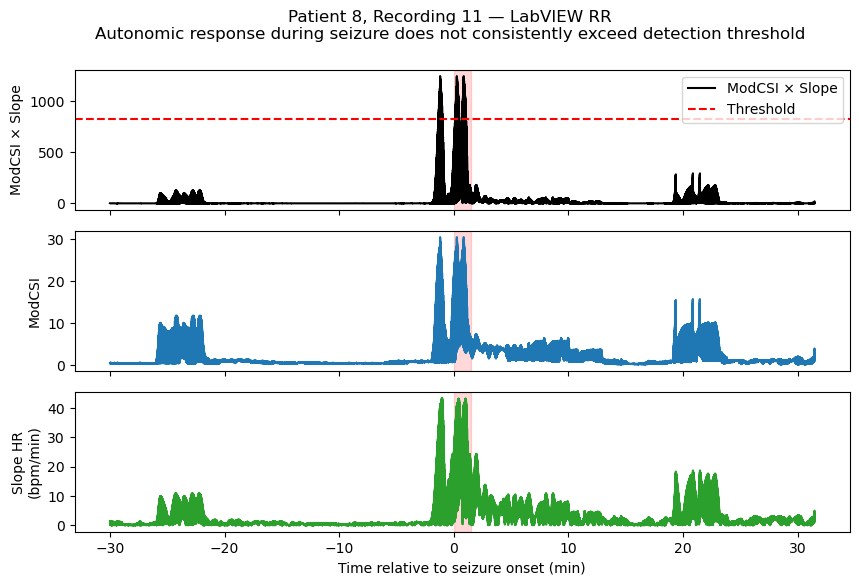

In [108]:
fig, axs = plt.subplots(
    3, 1,
    figsize=(10, 6),
    sharex=True,
    gridspec_kw={"hspace": 0.15}
)

# -------- Panel 1: ModCSI × Slope --------
axs[0].plot(t_min, g["ModCSI100_filt_x_SlopeHR"], label="ModCSI × Slope", color="black")
axs[0].axhline(
    g["thr_modcsi"].iloc[0],
    color="red", linestyle="--", label="Threshold"
)
axs[0].axvspan(0, (t1 - t0)/60, color="red", alpha=0.15)
axs[0].set_ylabel("ModCSI × Slope")
axs[0].legend(loc="upper right")

# -------- Panel 2: ModCSI --------
axs[1].plot(t_min, g["ModCSI100_filt"], color="tab:blue")
axs[1].axvspan(0, (t1 - t0)/60, color="red", alpha=0.15)
axs[1].set_ylabel("ModCSI")

# -------- Panel 3: SlopeHR --------
axs[2].plot(t_min, g["SlopeHR100_abs_bpm_per_min"], color="tab:green")
axs[2].axvspan(0, (t1 - t0)/60, color="red", alpha=0.15)
axs[2].set_ylabel("Slope HR\n(bpm/min)")
axs[2].set_xlabel("Time relative to seizure onset (min)")

plt.suptitle(
    f"Patient {pid}, Recording {rid} — LabVIEW RR\n"
    "Autonomic response during seizure does not consistently exceed detection threshold",
    y=0.98
)

plt.show()


In [109]:
df_seiz = pd.read_csv(paths.seizure_events_csv)
df_seiz.head()

,recording_uid,patient_id,enrollment_id,recording_id,seizure_id,t0,t1,duration_s,absolute_start,absolute_end,t0_video,t1_video,absolute_start_video,absolute_end_video,t0_clinical,t1_clinical,absolute_start_clinical,absolute_end_clinical,trim_start_s,trim_end_s
0,0,1,NaN,1,1,130087.0,130128.0,41.0,2016-02-23 23:14:01,2016-02-23 23:14:42,130087.0,130128.0,2016-02-23 23:14:01,2016-02-23 23:14:42,130087.0,130128.0,2016-02-23 23:12:21,2016-02-23 23:13:02,100,300
1,1,1,NaN,2,2,46863.0,46885.0,22.0,2016-02-25 05:21:03,2016-02-25 05:21:25,46863.0,46885.0,2016-02-25 05:21:03,2016-02-25 05:21:25,46848.0,46940.0,2016-02-25 05:15:48,2016-02-25 05:17:20,300,300
2,1,1,NaN,2,3,133880.0,133910.0,30.0,2016-02-26 05:31:20,2016-02-26 05:31:50,133880.0,133910.0,2016-02-26 05:31:20,2016-02-26 05:31:50,133853.0,133894.0,2016-02-26 05:25:53,2016-02-26 05:26:34,300,300
3,2,2,NaN,1,1,3109.0,3144.0,35.0,2016-05-03 14:12:34,2016-05-03 14:13:09,3109.0,3144.0,2016-05-03 14:12:34,2016-05-03 14:13:09,3102.0,3207.0,2016-05-03 14:10:47,2016-05-03 14:12:32,100,20
4,2,2,NaN,1,2,5741.0,5778.0,37.0,2016-05-03 14:56:26,2016-05-03 14:57:03,5741.0,5778.0,2016-05-03 14:56:26,2016-05-03 14:57:03,5725.0,5781.0,2016-05-03 14:54:30,2016-05-03 14:55:26,100,20


In [112]:
df_seiz[df_seiz["patient_id"] == 5]

,recording_uid,patient_id,enrollment_id,recording_id,seizure_id,t0,t1,duration_s,absolute_start,absolute_end,t0_video,t1_video,absolute_start_video,absolute_end_video,t0_clinical,t1_clinical,absolute_start_clinical,absolute_end_clinical,trim_start_s,trim_end_s
16,6,5,NaN,1,1,71939.0,71966.0,27.0,2016-10-13 07:26:31,2016-10-13 07:26:58,71939.0,71966.0,2016-10-13 07:26:31,2016-10-13 07:26:58,71965.0,72085.0,2016-10-13 07:04:27,2016-10-13 07:06:27,1350,1800
17,6,5,NaN,1,2,98397.0,98512.0,115.0,2016-10-13 14:47:29,2016-10-13 14:49:24,98397.0,98512.0,2016-10-13 14:47:29,2016-10-13 14:49:24,98418.0,98511.0,2016-10-13 14:25:20,2016-10-13 14:26:53,1350,1800
18,6,5,NaN,1,3,101338.0,101466.0,128.0,2016-10-13 15:36:30,2016-10-13 15:38:38,101338.0,101466.0,2016-10-13 15:36:30,2016-10-13 15:38:38,101336.0,101466.0,2016-10-13 15:13:58,2016-10-13 15:16:08,1350,1800
